# LitServe + Ollama Tool Calling

## Install

In [ ]:
!conda create -n litserve python=3.10 -y
!conda activate litserve

In [ ]:
!git clone https://github.com/Lightning-AI/LitServe
%cd LitServe
!pip install -r requirements.txt

In a separate terminal, run:

In [ ]:
!python server.py

Which will run the code below. Do not run it in the notebook because the API watches for changes and does not work well in the notebook environment. 

The server is set up for black-forest-labs/FLUX.1-schnell served in FP8 with dynamic quantization applied to the full precision weights.

In [ ]:
from io import BytesIO
from fastapi import Response
import torch
import time
import litserve as ls
from optimum.quanto import freeze, qfloat8, quantize
from diffusers import FlowMatchEulerDiscreteScheduler, AutoencoderKL
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
from diffusers.pipelines.flux.pipeline_flux import FluxPipeline
from transformers import CLIPTextModel, CLIPTokenizer,T5EncoderModel, T5TokenizerFast

class FluxLitAPI(ls.LitAPI):
    def setup(self, device):
        # Load the model
        scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="scheduler", revision="refs/pr/1")
        text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.bfloat16)
        tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.bfloat16)
        text_encoder_2 = T5EncoderModel.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="text_encoder_2", torch_dtype=torch.bfloat16, revision="refs/pr/1")
        tokenizer_2 = T5TokenizerFast.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="tokenizer_2", torch_dtype=torch.bfloat16, revision="refs/pr/1")
        vae = AutoencoderKL.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="vae", torch_dtype=torch.bfloat16, revision="refs/pr/1")
        transformer = FluxTransformer2DModel.from_pretrained("black-forest-labs/FLUX.1-schnell", subfolder="transformer", torch_dtype=torch.bfloat16, revision="refs/pr/1")

        # quantize to 8-bit to fit on an L4
        quantize(transformer, weights=qfloat8)
        freeze(transformer)
        quantize(text_encoder_2, weights=qfloat8)
        freeze(text_encoder_2)

        self.pipe = FluxPipeline(
            scheduler=scheduler,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            text_encoder_2=None,
            tokenizer_2=tokenizer_2,
            vae=vae,
            transformer=None,
        )
        self.pipe.text_encoder_2 = text_encoder_2
        self.pipe.transformer = transformer
        self.pipe.enable_model_cpu_offload()
    

    def decode_request(self, request):
        # Extract prompt from request
        prompt = request["prompt"]
        return prompt

    def predict(self, prompt):
        # Generate image from prompt
        image = self.pipe(
            prompt=prompt, 
            width=1024,
            height=1024,
            num_inference_steps=4, 
            generator=torch.Generator().manual_seed(int(time.time())),
            guidance_scale=1.0,
        ).images[0]

        return image

    def encode_response(self, image):
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        return Response(content=buffered.getvalue(), headers={"Content-Type": "image/png"})

# Starting the server
if __name__ == "__main__":
    api = FluxLitAPI()
    server = ls.LitServer(api, timeout=False)
    server.run(port=8000)


Next, you can query the server through this request.

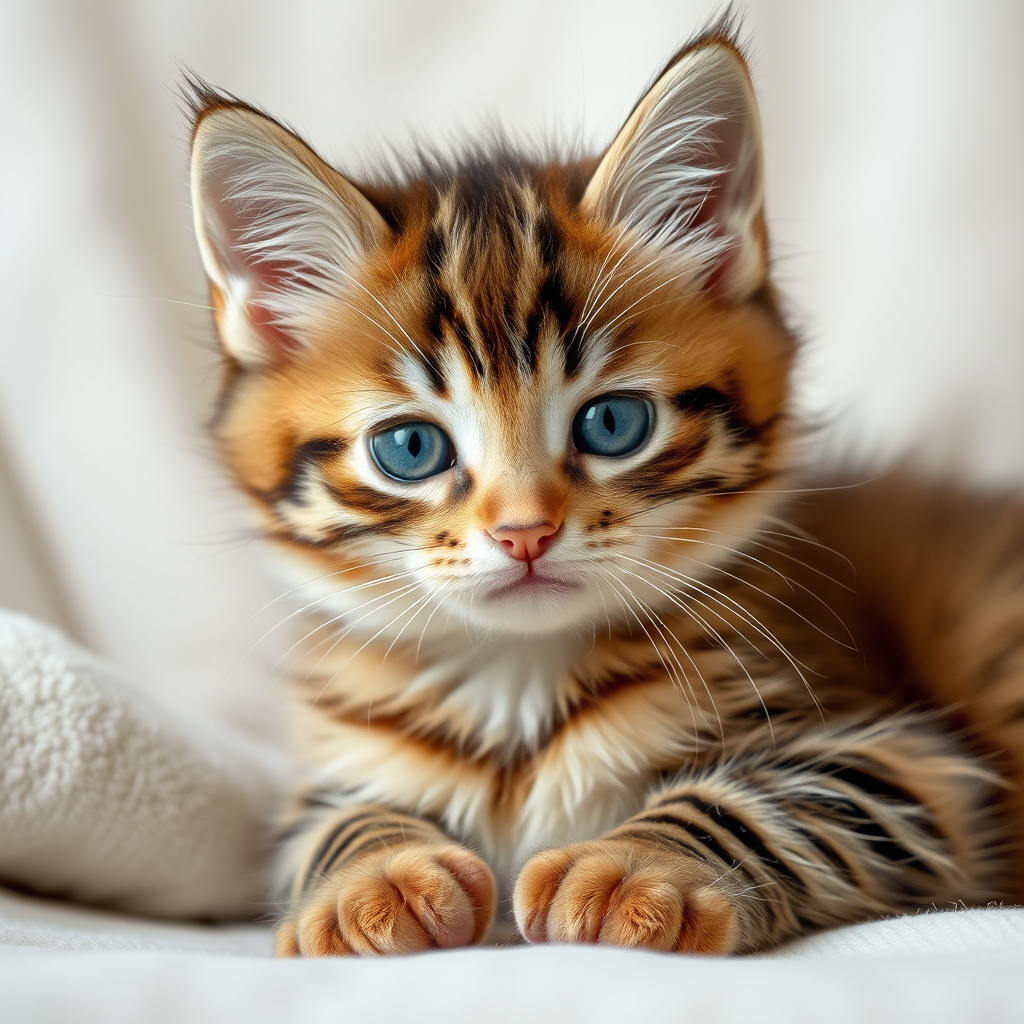

In [3]:
from PIL import Image
import requests
import io
from IPython.display import display

prompt = "a cute kitty"

# Send the POST request to your LitServe server
response = requests.post("http://127.0.0.1:8000/predict", json={"prompt": prompt})

if response.status_code == 200:
    # Read the image from the response content
    image = Image.open(io.BytesIO(response.content))
    
    # Display the image directly in the notebook
    display(image)
else:
    print(f"Failed to retrieve image. Response:\n{response.text}")


Now, what if this was usable by an LLM in the same way that something like DALL-E 3 works? That would allow us to have utilize some prompt refining techniques to increase the quality of the output. 

To start implementing this, we can wrap our request in a class:

In [5]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [6]:
import requests
from PIL import Image
import io
from IPython.display import display
import os
from dotenv import load_dotenv

class FluxLitServeRequest:
    def __init__(self, env_path=".env"):
        # Load environment variables from the .env file
        load_dotenv(dotenv_path=env_path)
        
        self.server_url = os.getenv("SERVER_URL", "http://127.0.0.1:8000/predict")
        self.default_prompt = "a cute kitty"

    def send_request(self, prompt=None):
        """Send a request to the server with the given prompt."""
        if prompt is None:
            prompt = self.default_prompt
        
        self.prompt = prompt
        self.response = requests.post(self.server_url, json={"prompt": self.prompt})
        return self.response.status_code

    def process_response(self):
        """Process the server response, displaying the image if successful."""
        if self.response.status_code == 200:
            # Read the image from the response content
            image = Image.open(io.BytesIO(self.response.content))
            
            # Display the image directly in the notebook
            display(image)
        else:
            print(f"Failed to retrieve image. Response:\n{self.response.text}")

# # Usage
# if __name__ == "__main__":
#     flux_request = FluxLitServeRequest()
#     status = flux_request.send_request()  # Uses default prompt from .env
#     print(f"Status: {status}")
#     flux_request.process_response()


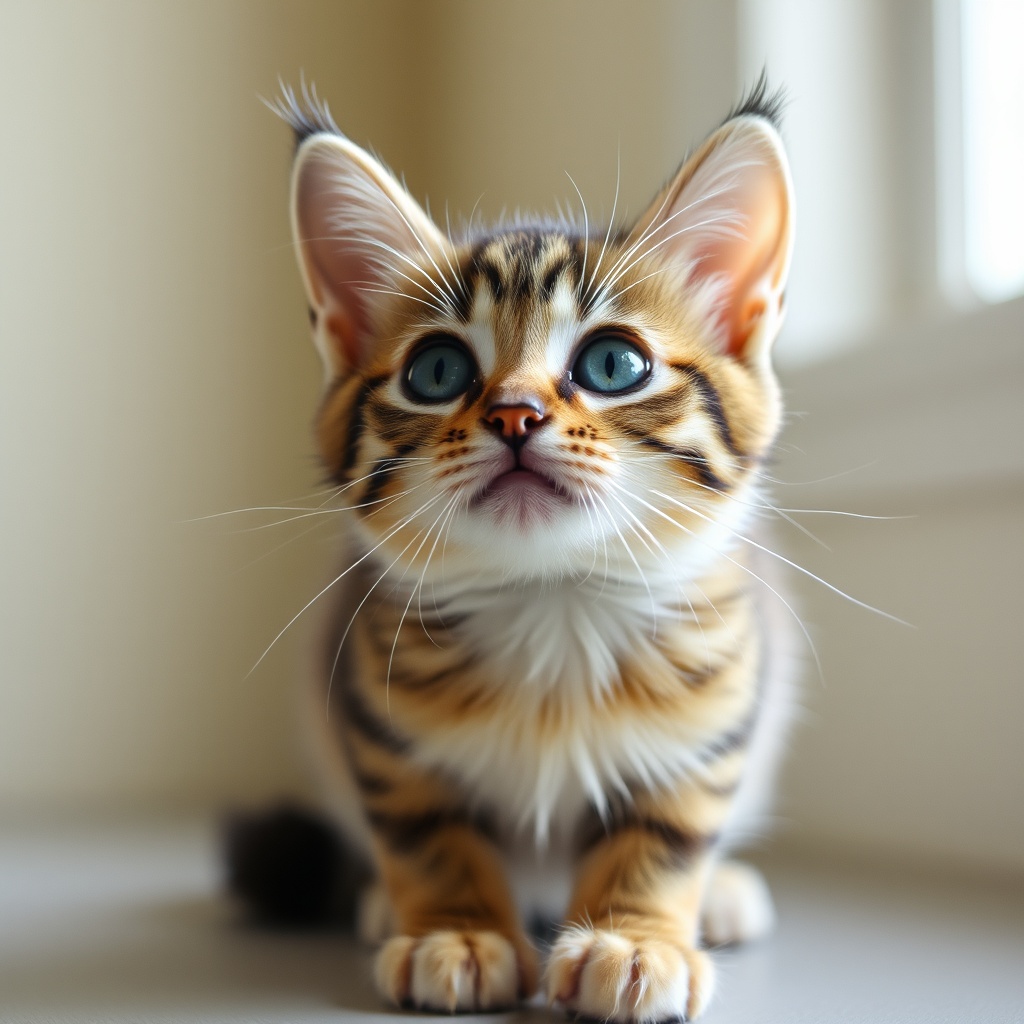

(<__main__.FluxLitServeRequest at 0x7dd64899fbb0>, 200)

In [7]:
import ollama

# Define the `query_flux` function
# Recommended to use this this function with your tool call instead for more predictable results
# Function to generate the image using the provided prompt
def query_flux(prompt):
    flux_request = FluxLitServeRequest()  # Initialize the request class
    status = flux_request.send_request(prompt)  # Send the prompt to the server
    flux_request.process_response()  # Process and display the response
    return flux_request, status

response = query_flux("a cute kitty")
response

In [11]:
!pip install ollama

Now that we have defined the tool, we can add it into an ollama request:

The model used the following functions:
[{'function': {'name': 'query_flux', 'arguments': {'prompt': 'a cute kitty wearing a Halloween costume'}}}]


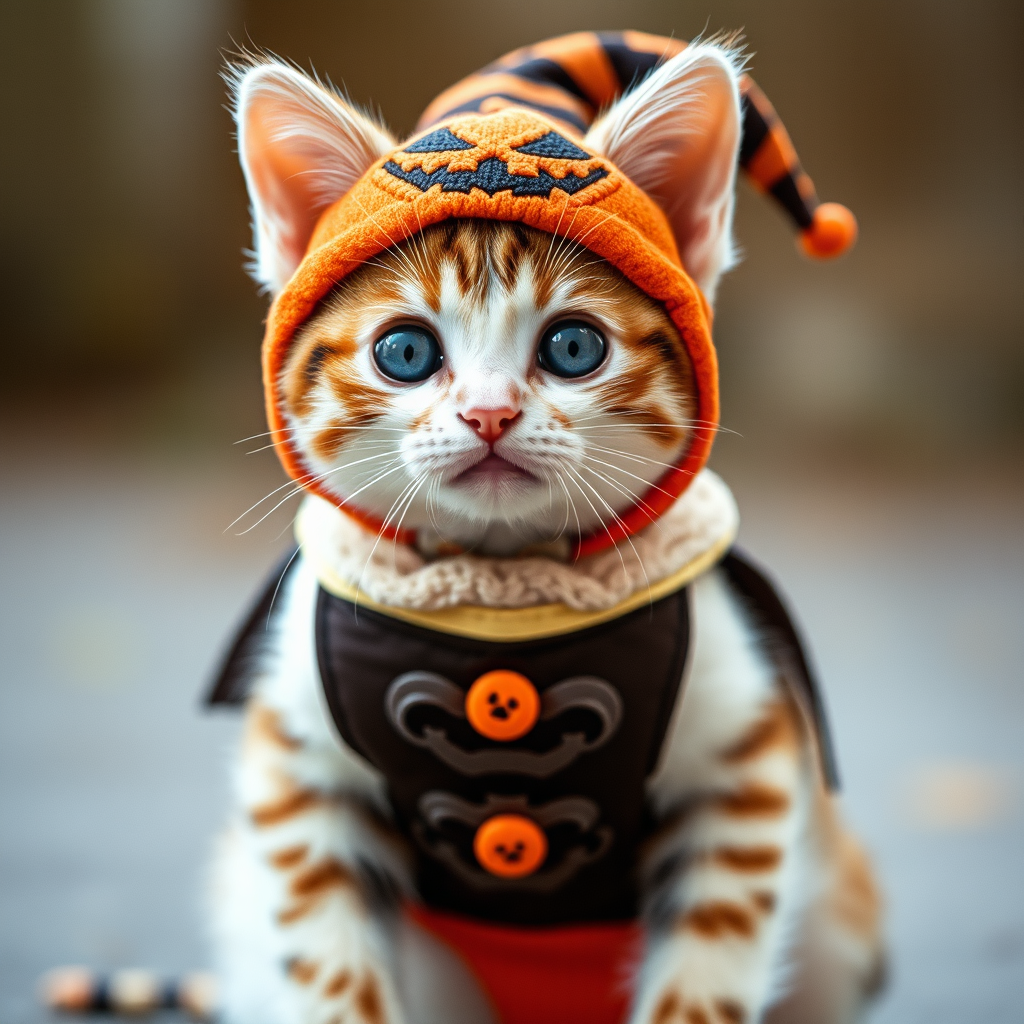

Image generated for prompt: 'a cute kitty wearing a Halloween costume' with status: 200


In [45]:
import ollama

# Initialize model and messages
model = 'llama3.1'

# System message guiding the model's behavior
system_message = {
    'role': 'system',
    'content': 'You are an AI assistant that can generate images based on text prompts.'
}

prompt = "can you generate me a cute kitty on halloween?"

# User message
user_message = {
    'role': 'user',
    'content': prompt
}

# Initialize conversation with the system message and user query
messages = [system_message, user_message]

# Define the tools available to the model
tools = [
    {
        'type': 'function',
        'function': {
            'name': 'query_flux',
            'description': 'Generates an image based on a text prompt and returns the result.',
            'parameters': {
                'type': 'object',
                'properties': {
                    'prompt': {
                        'type': 'string',
                        'description': 'The text prompt to generate the image from.',
                    },
                },
                'required': ['prompt'],
            },
        },
    }
]

# Model sends the query and decides to use the `query_flux` tool
response = ollama.chat(
    model=model,
    messages=messages,
    tools=tools
)

# Append the model's response to the existing messages
messages.append(response['message'])

# Check if the model decided to use the provided function
if not response['message'].get('tool_calls'):
    print("The model didn't use any function. Its response was:")
    print(response['message']['content'])
else:
    print("The model used the following functions:")
    print(response['message']['tool_calls'])
    # Process the tool call
    tool_call = response['message']['tool_calls'][0]
    function_name = tool_call['function']['name']
    prompt = tool_call['function']['arguments']['prompt']
    
    if function_name == 'query_flux':
        # Call the query_flux function with the extracted prompt
        flux_request, status = query_flux(prompt)
        
        # The image should already be displayed by `flux_request.process_response()`
        print(f"Image generated for prompt: '{prompt}' with status: {status}")


If you are interested in automated prompt improvement, this version of the tool call utilizes a second function that allows the model to 'choose' whether the prompt needs to be improved. 

This is very experimental and I dont think it actually works very well. The code does work and the fundamental idea works as expected. I just dont like the images more than using my own prompts.

Use this at your own risk. I would only use it if you want to improve it or tailor it to your specific use case where this is neccesary.

In [9]:
# Optional: function to optimze the prompt
# This is not very well optimized, but its more of a proof of concept rather than a final solution
def optimize_prompt(prompt):
    optimization_message = {
        'role': 'system',
        'content': """
        Optimize the following prompt for the best possible image generation while strictly adhering to the user's original intent. Apply these techniques:
        1. Enhance descriptive language: Use vivid, specific adjectives and adverbs.
        2. Improve composition: Suggest spatial relationships and focal points if applicable.
        3. Add relevant artistic styles or techniques if appropriate.
        4. Specify lighting, color, and mood if not already present.
        5. Include relevant details that support the main concept.
        6. Ensure proper grammar and clear sentence structure.
        7. Maintain the original subject and core idea.
        8. Do not add new main elements or change the fundamental concept.
        9. Keep the optimized prompt concise and focused.

        Format the optimized prompt as a single paragraph without numbering or bullet points.
        """
    }
    
    # Simulate an API call to the model to optimize the prompt
    messages = [optimization_message, {'role': 'user', 'content': prompt}]
    response = ollama.chat(
        model='llama3.1',
        messages=messages
    )
    
    optimized_prompt = response['message']['content']
    
    # Additional step to ensure the optimized prompt isn't too long
    max_length = 300  # Adjust this value as needed
    if len(optimized_prompt) > max_length:
        truncation_message = {
            'role': 'system',
            'content': f"The optimized prompt is too long. Please shorten it to a maximum of {max_length} characters while preserving the most important elements and the user's original intent."
        }
        messages.append({'role': 'assistant', 'content': optimized_prompt})
        messages.append(truncation_message)
        
        response = ollama.chat(
            model='llama3.1',
            messages=messages
        )
        optimized_prompt = response['message']['content']
    
    return optimized_prompt

Now that the prompt refinement function is complete, you can make another request.

The model used the following functions:
[{'function': {'name': 'query_flux', 'arguments': {'prompt': 'a high-quality, vivid, and detailed black cat in a spooky Halloween atmosphere with autumn leaves, jack-o-lanterns, and other festive elements'}}}]


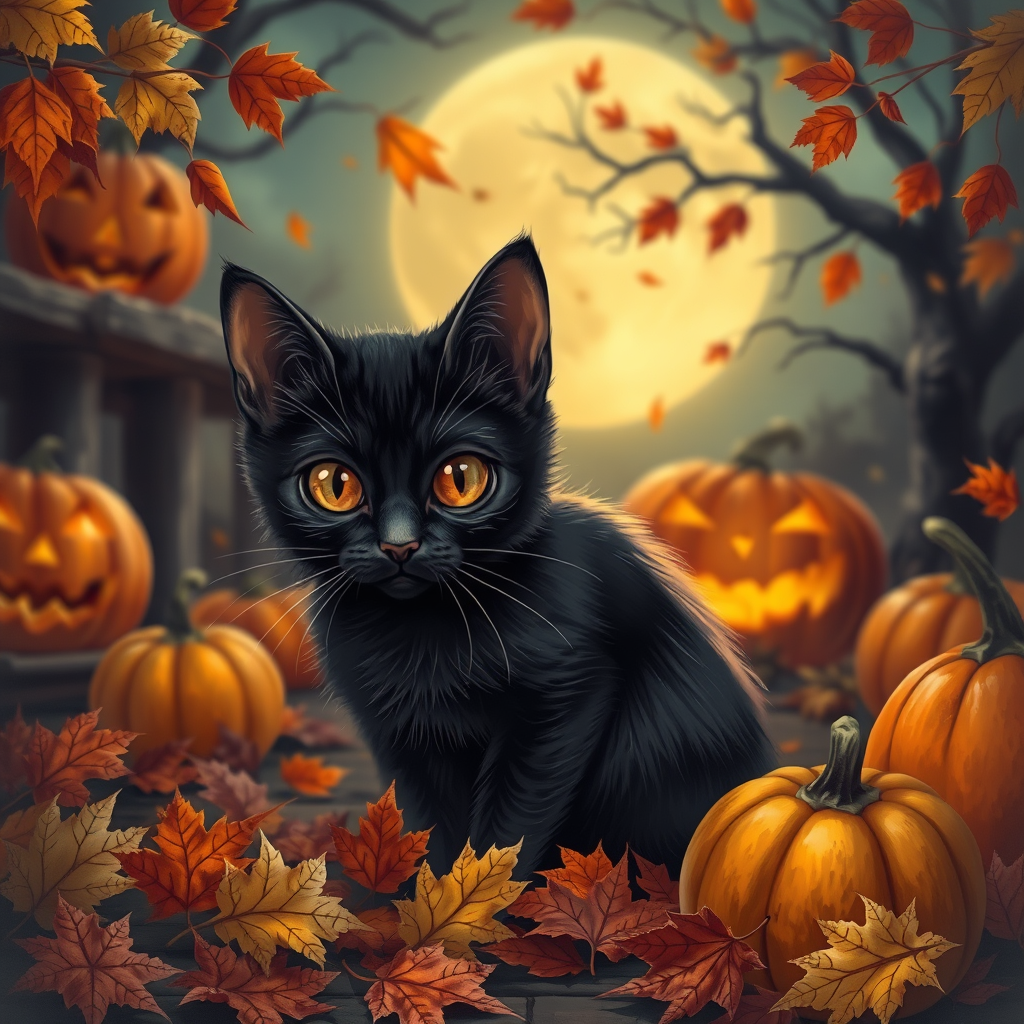

Image generated for prompt: 'a high-quality, vivid, and detailed black cat in a spooky Halloween atmosphere with autumn leaves, jack-o-lanterns, and other festive elements' with status: 200


In [16]:
# Initialize model and messages
model = 'llama3.1'

# System message guiding the model's behavior
system_message = {
    'role': 'system',
    'content': """
Optimize the given prompt for complex image generation:

    1. Analyze: Identify main subject, style, mood, and specific details.

    2. Enhance clarity: Use precise language, avoid ambiguity, specify colors, textures, lighting.

    3. Add artistic elements: Suggest art styles, techniques, mediums.

    4. Deepen context: Describe setting, atmosphere, time, weather.

    5. Improve composition: Suggest framing, perspective, focal points.

    6. Boost visual interest: Add dynamic elements, contrasts in color/texture/size.

    7. Consider AI capabilities: Use AI-friendly terms, avoid challenging elements.

    8. Ensure coherence: Make elements work together, avoid contradictions.

    9. Optimize for AI: Use clear language, separate elements with punctuation.

    10. Refine: Combine elements into a detailed, concise, comprehensive prompt.

    11. Prompt should be under 75 characters.

    Apply these guidelines to create an optimized, vivid, AI-friendly image generation prompt. Make sure the prompt is concise and sounds human.
    Generate only the prompt and nothing else.
"""
}

# to ensure the model uses both functions, the prompt engineering is a little weird.
# The model will first optimize the prompt and then generate the image
# If you only address one of the functions, the model will only use that function, e.g:
# prompt = "optimize this prompt: 'generate me a black cat on halloween'"
# or
# prompt = "generate me an image of black cat on halloween"

prompt = "optimize this prompt: 'generate me a black cat on halloween' and generate the image once its done"

# User message
user_message = {
    'role': 'user',
    'content': prompt
}

# Initialize conversation with the system message and user query
messages = [system_message, user_message]

# Define the tools available to the model
tools = [
    {
        'type': 'function',
        'function': {
            'name': 'optimize_prompt',
            'description': 'Optimizes the given text prompt to enhance image generation quality.',
            'parameters': {
                'type': 'object',
                'properties': {
                    'prompt': {
                        'type': 'string',
                        'description': 'The text prompt to optimize.',
                    },
                },
                'required': ['prompt'],
            },
        },
    },
    {
        'type': 'function',
        'function': {
            'name': 'query_flux',
            'description': 'Generates an image based on a text prompt and returns the result.',
            'parameters': {
                'type': 'object',
                'properties': {
                    'prompt': {
                        'type': 'string',
                        'description': 'The text prompt to generate the image from.',
                    },
                },
                'required': ['prompt'],
            },
        },
    }
]

# Step 1: Model sends the query and decides whether to call one or both tools
response = ollama.chat(
    model=model,
    messages=messages,
    tools=tools
)

# Step 2: Append the model's response to the existing messages
messages.append(response['message'])

# Step 2: Handle the model's decision
if not response['message'].get('tool_calls'):
    print("The model didn't use any function. Its response was:")
    print(response['message']['content'])
else:
    print("The model used the following functions:")
    print(response['message']['tool_calls'])
    optimized_prompt = None
    
    for tool_call in response['message']['tool_calls']:
        function_name = tool_call['function']['name']
        prompt = tool_call['function']['arguments']['prompt']
        
        if function_name == 'optimize_prompt':
            optimized_prompt = tool_call['function']['arguments']['prompt']
            print(f"Prompt optimized to: '{optimized_prompt}'")
        
        if function_name == 'query_flux':
            final_prompt = optimized_prompt if optimized_prompt else prompt
            image, status = query_flux(final_prompt)
            print(f"Image generated for prompt: '{final_prompt}' with status: {status}")
